In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline

/home/philip/.conda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def sigmoid(x):
    return 1.0 / (1+np.exp(-x))
def sigmoid_gradient(y):
    return y*(1.0-y)
sigmoid = np.vectorize(sigmoid)
sigmoid_gradient = np.vectorize(sigmoid_gradient)
def batch_gen(data,batch_size):
    full_len = len(data)
    start = 0
    while True:
        if start+batch_size<full_len:
            start+=batch_size
            yield data[start-batch_size:start]
        else:
            temp_start = start
            start = start+batch_size-full_len
            yield data[temp_start:]+data[:start]

def binary_entropy(y_true,y_pred):
    return -1*(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
            
class NN_layer(object):
    def __init__(self,input_size,hidden_size):
        std=1e-4
        self.weights = std * np.random.random((input_size,hidden_size))
        self.bias = np.zeros(hidden_size)
    def forward(self,input_array):
        self.input = input_array
        self.ih = np.dot(input_array,self.weights)
        self.o = sigmoid(self.bias+self.ih)
        return self.o
    def backward(self,error_array,learning_rate):
        self.delta = sigmoid_gradient(self.o)*error_array
        self.delta = error_array
        self.g_bias = (self.ih+self.bias)*self.bias*self.delta
        self.g_ih = (self.ih+self.bias)*self.ih*self.delta
        self.g_input = np.dot(self.g_ih, self.weights.T)
        self.weights -= learning_rate * np.dot(self.input.T,self.g_ih)
        self.bias -= learning_rate * np.sum(self.g_bias,axis=0)
        return self.g_input

class MLP():
    def __init__(self,input_size,hidden_unit, output_size):
        self.num_of_layer = len(hidden_unit)
        self.size = [input_size] + hidden_unit + [output_size]
        self.layers = [NN_layer(self.size[i],self.size[i+1]) for i in range(self.num_of_layer+1)]
        self.losses = []
        self.valid_acc = []
    def forward(self, X):
        feed = X
        for layer in self.layers:
            out = layer.forward(feed)
            feed = out
        return out
    def backward(self, error,learning_rate):
        error_bp = error
        for i in range(self.num_of_layer,-1,-1):
            error_bp = self.layers[i].backward(error_bp,learning_rate)
    def train(self, X, y,learning_rate):
        output = self.forward(X)
        loss = binary_entropy(y, output)
        self.backward(loss,learning_rate)
        return loss.mean()
    def fit(self, X, y, epoch, batch_size=1, learning_rate=0.1,shuffle=True,validation=False, valid_iter=None,valid_X=None,valid_y=None):
        data = list(zip(X,y))
        if shuffle:
            np.random.shuffle(data)
        batch_num = len(X)*epoch//batch_size+int((len(X)*epoch)%batch_size>0)
        data_gen = batch_gen(data,batch_size)
        for iteration in tqdm.tqdm(range(batch_num)):
            batch_X,batch_y = zip(*next(data_gen))
            loss = self.train(np.array(batch_X),np.array(batch_y),learning_rate)
            self.losses.append(loss)
            if validation and ((iteration+1)%valid_iter==0):
                valid_pred = self.forward(valid_X)
                acc = accurcy(valid_y, valid_pred)
                self.valid_acc.append(acc)

In [3]:
def accurcy(y_true,y_pred):
    return np.array(np.argmax(y_pred,axis=1) == np.argmax(y_true,axis=1),dtype=np.float).mean()

In [4]:
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype=np.int)
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=np.float32)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [5]:
model = MLP(784,[1000,100],10)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((60000,784))
y_train = to_categorical(y_train)

In [7]:
model.fit(x_train,y_train,epoch=10,batch_size=256,shuffle=True,learning_rate=1)

  5%|▌         | 120/2344 [00:49<15:08,  2.45it/s]

KeyboardInterrupt: 

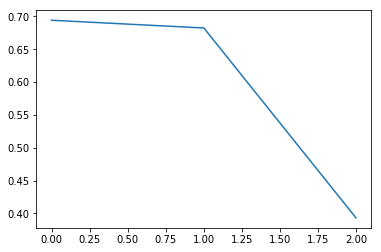

In [8]:
plt.plot(model.losses)

In [9]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [10]:
iris = datasets.load_iris()
X = iris.data
y = to_categorical(iris.target)

In [11]:
print(X.shape[-1], y.shape[-1])

4 3


In [15]:
train_val_X,test_X,train_val_y, test_y = train_test_split(X,y,test_size=0.2)
train_X,val_X,train_y,val_y = train_test_split(train_val_X,train_val_y,test_size=0.2)

In [16]:
model = MLP(4,[16,16,8],3)

In [17]:
model.fit(train_X,train_y,epoch=100000,batch_size=64,learning_rate=100,validation=True, valid_iter=100,valid_X=val_X,valid_y=val_y)

  0%|          | 0/150000 [00:00<?, ?it/s]/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply
  9%|▉         | 13990/150000 [00:44<07:14, 312.89it/s]

KeyboardInterrupt: 

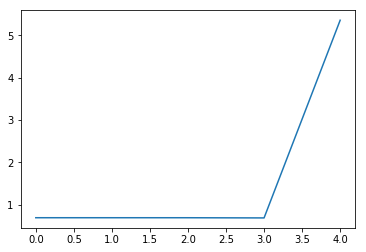

  9%|▉         | 13990/150000 [01:00<09:43, 232.93it/s]

In [18]:
plt.plot(model.losses)

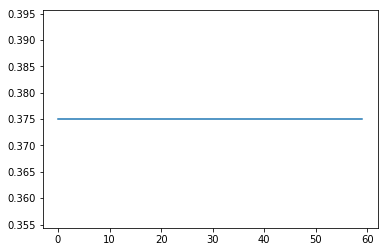

In [37]:
plt.plot(model.valid_acc)